In [1]:
"""
Polynomial Regression: Study of the effect of soot on the antenna sensor frequencies
Publication: Microstrip patch antenna for simultaneous temperature sensing and superstrate characterization
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [2]:
np.random.seed(42)
%matplotlib inline

In [3]:
# LOAD DATA FROM THE EXCEL OR TXT FILE
df = pd.read_csv('h_ff_data.csv')

In [4]:
df.head(5)

,Superstrate_thickness,Frequency10,Frequency01
0,0,2.550002,3.292010
1,0,2.550006,3.292010
2,0,2.550004,3.292005
3,0,2.550008,3.292009
4,0,2.550008,3.292007


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Superstrate_thickness  35000 non-null  int64  
 1   Frequency10            35000 non-null  float64
 2   Frequency01            35000 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 820.4 KB


In [6]:
df.describe()

,Superstrate_thickness,Frequency10,Frequency01
count,35000.000000,35000.000000,35000.000000
mean,785.714286,2.511687,3.246670
std,523.289894,0.020004,0.023489
min,0.000000,2.492924,3.224697
25%,280.000000,2.492980,3.225512
50%,770.000000,2.504551,3.237859
75%,1270.000000,2.529607,3.267559
max,1600.000000,2.550010,3.292010


In [7]:
h = df['Superstrate_thickness']
f10 = df.Frequency10
f01 = df.Frequency01

In [8]:
x = np.array(h).reshape(-1, 1)  # Feature
Y = np.c_[f10, f01]  # Target value
print(f'Multioutput target shape: {Y.shape}')

Multioutput target shape: (35000, 2)


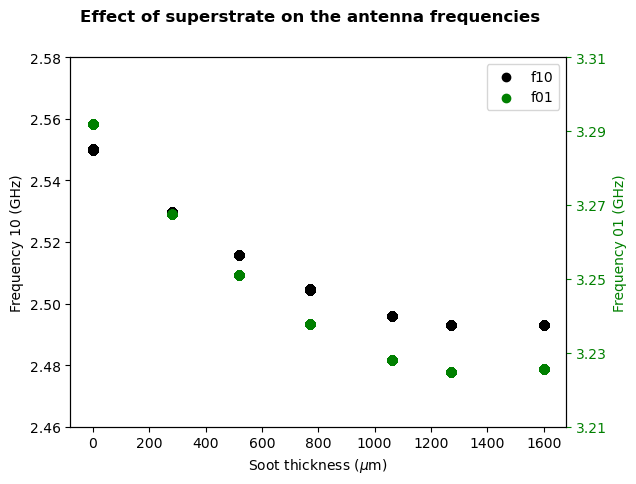

In [9]:
# VISUALIZE INPUTS AND TARGETS
fig, ax1 = plt.subplots()
ax1.scatter(x, Y[:, 0], color='k', marker='o', label='f10')
ax1.set_ylabel('Frequency 10 (GHz)', color='k')
ax1.set_xlabel('Soot thickness ($\\mu$m)')
ax1.tick_params('y', colors='k')
ax1.set_ylim(2.46, 2.58)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.scatter(x, Y[:, 1], color='g', marker='o', label='f01')
ax2.set_ylabel('Frequency 01 (GHz)', color='g')
ax2.tick_params('y', colors='g')
ax2.set_ylim(3.21, 3.31)
ax2.set_yticks(np.arange(3.21, 3.31, 0.02))

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
fig.suptitle('Effect of superstrate on the antenna frequencies', weight='bold')
plt.show()


In [10]:
# Split the data into training and test sets
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=42)

print(f'Number of data points for training: {x_train.shape[0]}')
print(f'Number of data points for testing: {x_test.shape[0]}')


Number of data points for training: 24500
Number of data points for testing: 10500


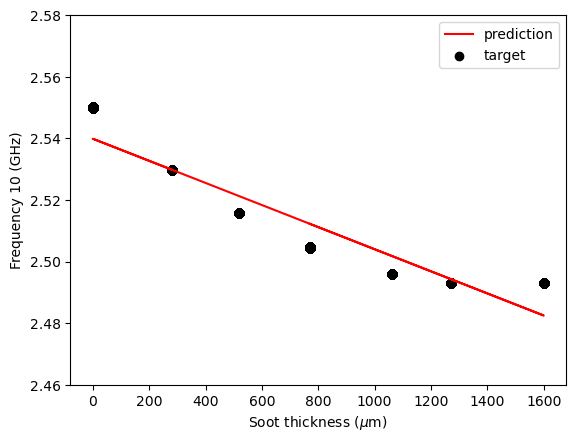

In [11]:
# CREATE AND FIT THE REGRESSION MODEL
# Fit temperature and features (f1 and f2)
model = MultiOutputRegressor(LinearRegression())
model.fit(x_train, Y_train)
Y_train_pred = model.predict(x_train)

# Visualizing the prediction for a single target
fig, ax1 = plt.subplots()
ax1.plot(x_train, Y_train_pred[:, 0], color='r', label='prediction')
ax1.scatter(x_train, Y_train[:, 0], color='k', marker='o', label='target')
ax1.set_ylabel('Frequency 10 (GHz)', color='k')
ax1.set_xlabel('Soot thickness ($\\mu$m)')
ax1.legend(loc='best')
ax1.set_ylim((2.46, 2.58))
plt.show()

In [12]:
# Note: The model is not doing well on the training set given the plot.
# We need to engineer some features to capture the behavior more accurately.

In [13]:
# FEATURE ENGINEERING AND FEATURE SCALING
# Function for data processing
def process_data(Xdata, Ydata, poly_order, seed=42):
    """
    Process data by adding polynomial features, splitting into training, CV, and test sets,
    and scaling the data.

    Arguments:
        - Xdata (numpy array): Input features.
        - Ydata (numpy array): Target values.
        - poly_order (int): Degree of polynomial features.
        - seed (int): Random number generator (default value 42).

    Returns:
        - X_train_mapped_scaled (numpy array): Scaled training set with polynomial features.
        - X_cv_mapped_scaled (numpy array): Scaled cross-validation set with polynomial features.
        - X_test_mapped (numpy array): Test set with polynomial features.
        - Y_train (numpy array): Training target values.
        - Y_cv (numpy array): Cross-validation target values.
        - Y_test (numpy array): Test target values.
        - sk_scaler: sklearn.preprocessing.StandardScaler object
    """

    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree=poly_order, include_bias=False)
    X_mapped = poly.fit_transform(Xdata)

    # Splitting raw data into training (60%), CV (20%), and test sets (20%)
    Xtrain_mapped, X_, Ytrain, Y_ = train_test_split(X_mapped, Ydata, train_size=0.6, random_state=seed)
    Xcv_mapped, Xtest_mapped, Ycv, Ytest = train_test_split(X_, Y_, test_size=0.5, random_state=seed)
    del (X_, Y_)

    # Scale the training set
    sk_scaler = StandardScaler()
    Xtrain_mapped_scaled = sk_scaler.fit_transform(Xtrain_mapped)
    Xcv_mapped_scaled = sk_scaler.transform(Xcv_mapped)
    Xtest_mapped_scaled = sk_scaler.transform(Xtest_mapped)

    # Verification: Print peak-to-peak range for training set before and after scaling
    print(f'Training set peak to peak range: {np.ptp(Xtrain_mapped_scaled, axis=0)}')
    print(f'Validation set peak to peak range: {np.ptp(Xcv_mapped_scaled, axis=0)}')
    print(f'Test set peak to peak range: {np.ptp(Xtest_mapped_scaled, axis=0)}')

    return Xtrain_mapped_scaled, Xcv_mapped_scaled, Xtest_mapped_scaled, Ytrain, Ycv, Ytest, sk_scaler

In [14]:
# Initialize lists
train_mses, cv_mses = [], []

# Loop over n times. Each adding one more degree of polynomial higher than the last.
n = 4  # Max. polynomial order to consider
degrees = np.arange(1, n + 1)
for deg in degrees:
    X_train_mapped_scaled, X_cv_mapped_scaled, X_test_mapped_scaled, Y_train, Y_cv, Y_test, _ = process_data(x, Y, deg)

    # Create and train the model
    model = MultiOutputRegressor(LinearRegression())
    model.fit(X_train_mapped_scaled, Y_train)

    # Compute the loss/cost functions
    train_mse = mse(Y_train, model.predict(X_train_mapped_scaled)) / 2
    cv_mse = mse(Y_cv, model.predict(X_cv_mapped_scaled)) / 2

    train_mses.append(train_mse)
    cv_mses.append(cv_mse)

Training set peak to peak range: [3.06453709]
Validation set peak to peak range: [3.06453709]
Test set peak to peak range: [3.06453709]
Training set peak to peak range: [3.06453709 2.95324311]
Validation set peak to peak range: [3.06453709 2.95324311]
Test set peak to peak range: [3.06453709 2.95324311]
Training set peak to peak range: [3.06453709 2.95324311 2.94916318]
Validation set peak to peak range: [3.06453709 2.95324311 2.94916318]
Test set peak to peak range: [3.06453709 2.95324311 2.94916318]
Training set peak to peak range: [3.06453709 2.95324311 2.94916318 2.9552481 ]
Validation set peak to peak range: [3.06453709 2.95324311 2.94916318 2.9552481 ]
Test set peak to peak range: [3.06453709 2.95324311 2.94916318 2.9552481 ]


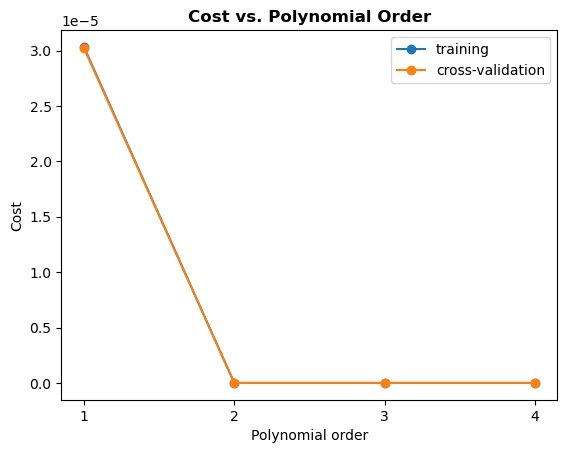

In [15]:
train_mses = np.array(train_mses)
cv_mses = np.array(cv_mses)

# Plot results for cost versus polynomial order for the training and cross-validation data
fig, ax = plt.subplots()
ax.plot(degrees, train_mses, '-o', label='training')
ax.plot(degrees, cv_mses, '-o', label='cross-validation')
ax.set_xlabel('Polynomial order')
ax.set_ylabel('Cost')
ax.set_title('Cost vs. Polynomial Order', weight='bold')
ax.set_xticks(np.arange(1, n+1))
ax.legend()


In [16]:
# FINALIZING THE MODEL
degree = 2  # Best polynomial order
X_train_mapped_scaled, X_cv_mapped_scaled, X_test_mapped_scaled, \
    Y_train, Y_cv, Y_test, scaler = process_data(x, Y, degree)

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_mapped_scaled, Y_train)

Training set peak to peak range: [3.06453709 2.95324311]
Validation set peak to peak range: [3.06453709 2.95324311]
Test set peak to peak range: [3.06453709 2.95324311]


MultiOutputRegressor(estimator=LinearRegression())

In [17]:
# Compute loss/cost functions
Cost_train = mse(Y_train, model.predict(X_train_mapped_scaled)) / 2
Cost_cv = mse(Y_cv, model.predict(X_cv_mapped_scaled)) / 2
Cost_test = mse(Y_test, model.predict(X_test_mapped_scaled)) / 2

In [18]:
print(f'Train: Cost {Cost_train:.3e} and Score {model.score(X_train_mapped_scaled, Y_train):.9f}')
print(f'Validation: Cost {Cost_cv:.3e} and Score {model.score(X_cv_mapped_scaled, Y_cv):.9f}')
print(f'Test: Cost {Cost_test:.3e} and Score {model.score(X_test_mapped_scaled, Y_test):.9f}')

Train: Cost 4.170e-12 and Score 0.999999982
Validation: Cost 4.117e-12 and Score 0.999999982
Test: Cost 4.168e-12 and Score 0.999999982


In [19]:
# Extract the trained base regressors from MultiOutputRegressor
base_final = model.estimators_

# Initialize lists to store coefficients and intercepts
W, b = [], []

# Loop through each target's base regressor to extract the parameters
for regressor in base_final:
    W.append(regressor.coef_)
    b.append(regressor.intercept_)

# Convert the lists to arrays
W_mapped = np.array(W)
b_mapped = np.array(b)

In [20]:
print(f'Coefficients for normalized data: \n{W_mapped}')
print(f'Intercepts for normalized data:\n{b_mapped}')

Coefficients for normalized data: 
[[-0.04214931  0.02442768]
 [-0.05064396  0.03003624]]
Intercepts for normalized data:
[2.51160364 3.24656975]


Text(0.5, 0.98, 'Predictions vs targets')

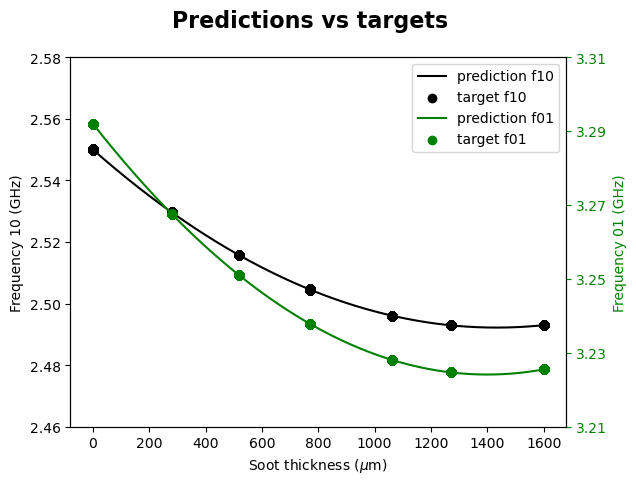

In [21]:
# Visualize curve fit
x_dummy = np.arange(np.min(x), np.max(x)).reshape(-1, 1)
X_mapped = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(x_dummy)
X_mapped_scaled = scaler.transform(X_mapped)
Y_dummy = np.dot(X_mapped_scaled, W_mapped.T) + b_mapped

fig, ax1 = plt.subplots()
ax1.plot(x_dummy, Y_dummy[:, 0], color='k', label='prediction f10')
ax1.scatter(x, Y[:, 0], color='k', marker='o', label='target f10')
ax1.set_ylabel('Frequency 10 (GHz)', color='k')
ax1.set_xlabel('Soot thickness ($\\mu$m)')
ax1.tick_params('y', colors='k')
ax1.set_ylim(2.46, 2.58)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x_dummy, Y_dummy[:, 1], color='g', label='prediction f01')
ax2.scatter(x, Y[:, 1], color='g', marker='o', label='target f01')
ax2.set_ylabel('Frequency 01 (GHz)', color='g')
ax2.tick_params('y', colors='g')
ax2.set_ylim(3.21, 3.31)
ax2.set_yticks(np.arange(3.21, 3.31, 0.02))

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
fig.suptitle('Predictions vs targets', fontsize=16, weight='bold')

In [22]:
# Predict the antenna frequencies with your input
user_in = float(input('Enter the superstrate thickness in microns: '))
user_in = np.reshape(user_in, (-1, 1))
user_mapped = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(user_in)
user_mapped_scaled = scaler.transform(user_mapped)
user_out = np.dot(user_mapped_scaled, W_mapped.T) + b_mapped
print(f'Prediction for a soot thickness of {np.squeeze(user_in)}: {np.squeeze(np.array(user_out))}')

Prediction for a soot thickness of 1600.0: [2.49297777 3.22550904]
